<a href="https://colab.research.google.com/github/JishnuJayaraj/ML/blob/master/NLP/_TrendDetection/NewsAggregator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://medium.com/@satyajitghana7/how-to-upgrade-to-25gb-ram-in-google-colab-possibly-w-tesla-p100-gpu-for-free-115e7679f5de

!nvidia-smi
!lscpu | grep 'Model name'
!lscpu | grep 'Core(s) per socket'
!lscpu | grep 'Thread(s) per core'
!free -h
# https://towardsdatascience.com/logging-with-weights-biases-da048e3cbc8b

# Tesla p100, Xeon 2,2
# 25gb RAM

Tue Oct 27 11:44:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

              total        used        free      shared  buff/cache   available
Mem:            25G        893M         22G        968K        2.3G         24G
Swap:            0B          0B          0B


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# multi class classification model

In [1]:
#changing the working directory
%cd /content/drive/My Drive/RokinData

#unzipping the zip files and deleting the zip files, !unzip \*.zip && rm *.zip
!unzip \*.zip -d /content
!rm *.zip

[Errno 2] No such file or directory: '/content/drive/My Drive/RokinData'
/content
Archive:  archive.zip
  inflating: /content/uci-news-aggregator.csv  


In [2]:
%cd /content

import pandas as pd
# https://archive.ics.uci.edu/ml/datasets/News+Aggregator
# (b = business, t = science and technology, e = entertainment, m = health
data = pd.read_csv('/content/uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])

/content


In [3]:
#M class has way less data than the orthers, thus the classes are unbalanced.
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

## Data Exploration

In [46]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
Entertainment = data[data.CATEGORY == "e"]
Business = data[data.CATEGORY == "b"]
Technology = data[data.CATEGORY == "t"]
Medicine = data[data.CATEGORY == "m"]

In [44]:
print(Entertainment.shape, Business.shape, Technology.shape, Medicine.shape )

(152469, 2) (115967, 2) (108344, 2) (45639, 2)


In [47]:
Entertainment_text = " ".join(Entertainment.TITLE.to_numpy().tolist())
Business_text = " ".join(Business.TITLE.to_numpy().tolist())
Technology_text = " ".join(Technology.TITLE.to_numpy().tolist())
Medicine_text = " ".join(Medicine.TITLE.to_numpy().tolist())


Entertainment_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(Entertainment_text)
Business_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(Business_text)
Technology_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(Technology_text)
Medicine_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(Medicine_text)


In [48]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();

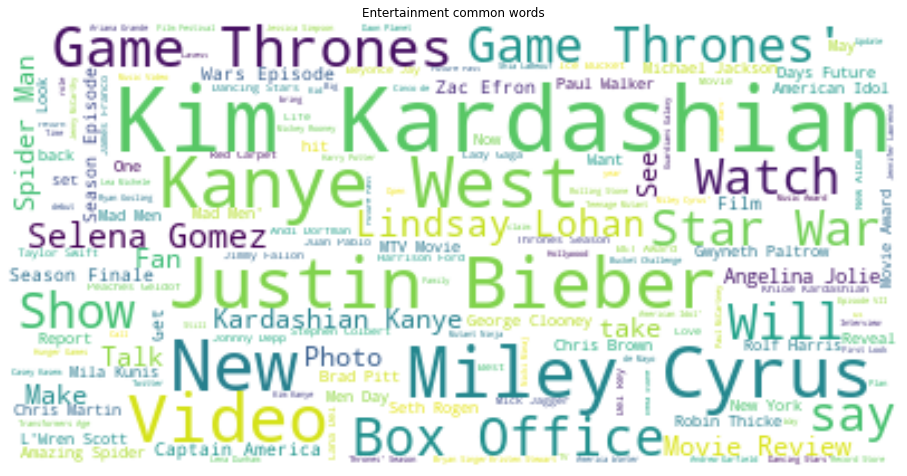

In [49]:
show_word_cloud(Entertainment_cloud, "Entertainment common words")

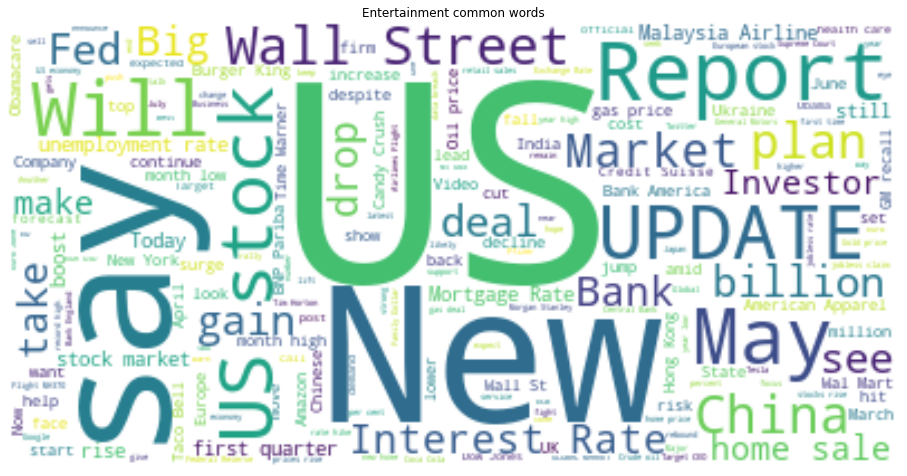

In [50]:
show_word_cloud(Business_cloud, "Entertainment common words")


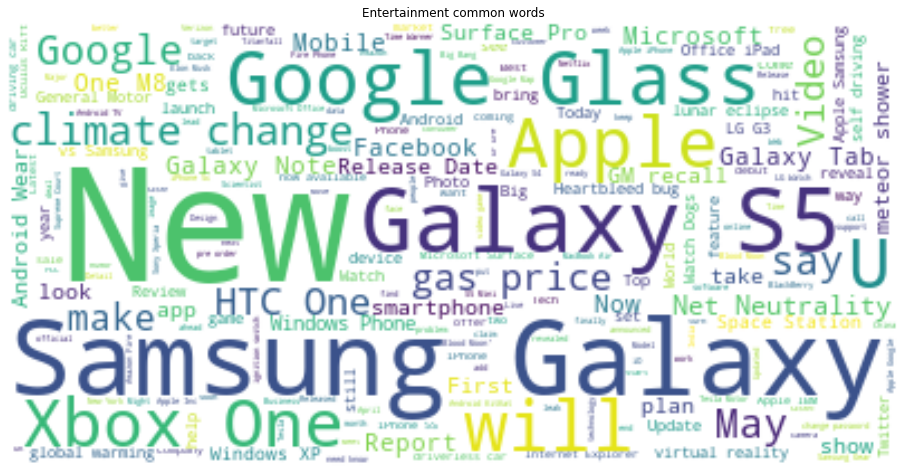

In [51]:
show_word_cloud(Technology_cloud, "Entertainment common words")

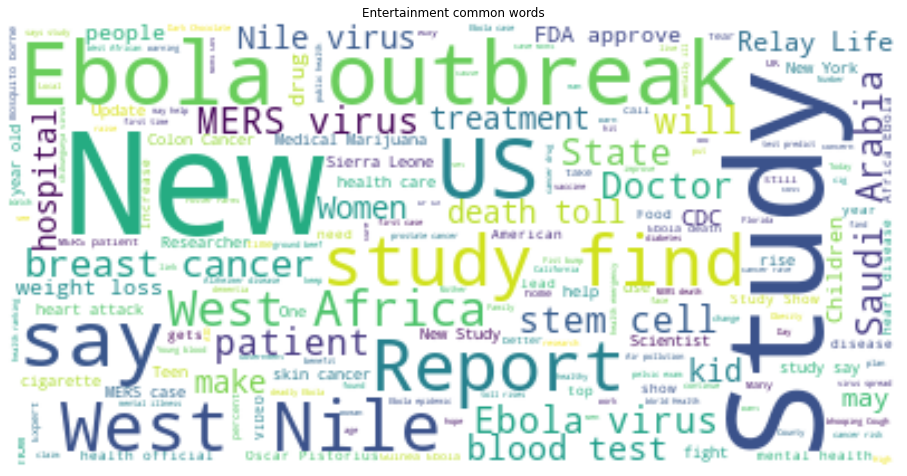

In [52]:
show_word_cloud(Medicine_cloud, "Entertainment common words")


## Data balancing

In [5]:
# make data balanced
import numpy as np
num_of_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))

concated['CATEGORY']=concated['CATEGORY'].replace(['e','b','t','m'],[0,1,2,3])
# 0 : Entertainment
# 1 : Business
# 2 : Technology
# 3 : Medicine
concated.head()

,TITLE,CATEGORY
103432,T-Mobile Billing Scandal: FTC Says Millions We...,2
165298,WHO says sending supplies for Ebola outbreak i...,3
123563,Apple replaces iPad 2 with iPad 4,2
480,"Jewelry, Maserati stolen from Miley Cyrus' house",0
102856,Report: Microsoft is planning thousands of lay...,2


In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, Y_train, Y_test = train_test_split(concated['TITLE'], 
                                                    concated['CATEGORY'], 
                                                    test_size=0.3, 
                                                    stratify=concated['CATEGORY'], 
                                                    random_state=42)

In [7]:
# convert y train an d y test to 1 hot encodings
y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(Y_test)

In [33]:

# TESTTTT
# pd.get_dummies(data["CATEGORY"])

# OR
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Enc_ohe, Enc_label = OneHotEncoder(), LabelEncoder()
# data["Dummies"] = Enc_label.fit_transform(data["CATEGORY"])
# DF_dummies2 = pd.DataFrame(Enc_ohe.fit_transform(data[["Dummies"]]).todense(), columns = Enc_label.classes_)
# # 
# DF_dummies2


def Onh_Enc(inputs):
  new = pd.DataFrame()
  new["Dummies"] = Enc_label.fit_transform(inputs)
  DF_dummies2 = pd.DataFrame(Enc_ohe.fit_transform(new[["Dummies"]]).todense(), columns = Enc_label.classes_)
  return(DF_dummies2)

In [39]:
import tensorflow_hub as hu
import tensorflow as tf
tf.config.list_physical_devices('GPU') #tf.test.is_gpu_available()

# encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
# encoder(['Hello World'])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [40]:
import tensorflow as tf
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

# sequential model that will encapsulate our layers.
model = tf.keras.models.Sequential()

# first layer will be a hub.KerasLayer for encoding the sentence
model.add(hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=True))
#      trainable=True: Denotes whether we want to finetune USE or not.
#      We set it to True, the embeddings present in USE are finetuned based on our downstream task.

# hidden layer

model.add(tf.keras.layers.Dense(64, activation='relu'))

# add secod hidden layer

# add dropout layer also

# <----------- Dense layer with single node to output classification
# 4 nodes for each class 
model.add(tf.keras.layers.Dense(4, activation='softmax'))

TensorFlow version:  2.3.0


In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 256,830,916
Trainable params: 256,830,916
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Training
model.compile(optimizer='adam',  # rmsprop, sgd
              loss='categorical_crossentropy',   # binary_crossentropy, 2 class
              metrics=['accuracy'])

In [42]:
# Tensorflow graph

# Load the TensorBoard notebook extension.
%load_ext tensorboard

from datetime import datetime
import tensorboard
from tensorflow import keras
tensorboard.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.3.0'

In [ ]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [43]:
history = model.fit(x_train, 
          y_train, 
          epochs=2,                            # increase the eposchs, add batch_size
          validation_data=(x_test, y_test))

Epoch 1/2
3938/3938 [==============================] - 319s 81ms/step - loss: 0.2336 - accuracy: 0.9193 - val_loss: 0.1691 - val_accuracy: 0.9415
Epoch 2/2
3938/3938 [==============================] - 317s 81ms/step - loss: 0.0569 - accuracy: 0.9813 - val_loss: 0.1855 - val_accuracy: 0.9414


In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
%tensorboard --logdir logs

In [32]:
# saving hsitory
with open('/trainHistoryDict', 'wb') as file_pi:
 pickle.dump(history.history, file_pi)

NameError: ignored

In [44]:
model.predict(["Samsung posts highest revenue ever after boost in flagship phone sales"])


array([[0.00187354, 0.3162586 , 0.67987734, 0.00199056]], dtype=float32)

In [45]:
pred = model.predict(["Samsung posts highest revenue ever after boost in flagship phone sales"])

labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[0.00187354 0.3162586  0.67987734 0.00199056]] science/tech


In [27]:
model.predict(["Wall Street sinks 3%, Dow at late July lows as pandemic surges"])

array([[5.0647388e-04, 9.9350435e-01, 6.7454431e-04, 5.3147497e-03]],
      dtype=float32)

In [28]:
model.predict(["Asia's COVID-19 control tempers global stock selloff, U.S. futures jump"])

array([[6.7414134e-05, 9.9931395e-01, 4.1164010e-04, 2.0694833e-04]],
      dtype=float32)

In [15]:
import pandas as pd
news = pd.DataFrame({"entertainment":[1,0,0,0],"business":[0,1,0,0],"tech":[0,0,1,0],"health":[0,0,0,1]}, index=None)

def get_news(row):
   for c in news.columns:
     if row[c]==1:
       return c

In [16]:
x = [1,0,0,0]
get_news(x)


TypeError: ignored

In [33]:
# plotting accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

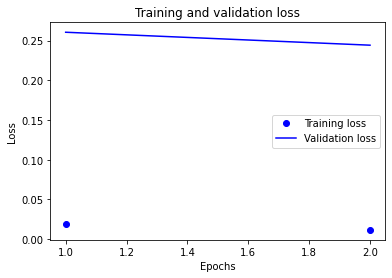

In [35]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

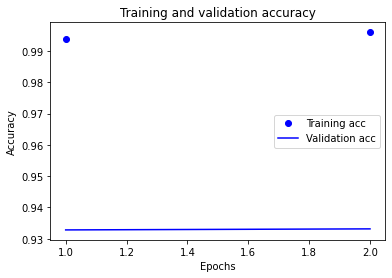

In [36]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

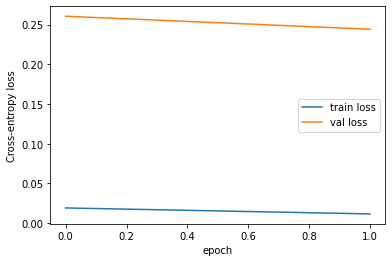

In [39]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();


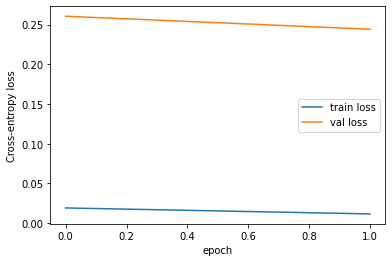

In [40]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [ ]:
# save the model


# Model trained on google news
https://tfhub.dev/google/nnlm-en-dim50/2

In [ ]:
embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1")
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

# Binary classification model

In [4]:
# Load Rokin Data
from google.colab import auth
auth.authenticate_user()

In [3]:
# Do not Run

from pathlib import Path
import os 

# -------------------- Enter Data to be read here ---------------------------
# article_data_english_october_from_2015.json.gz    ;     article_data_english_october.json.gz    ;    /content/drive/My Drive/RokinData/from2019.pkl
dataset_version = "from2019.pkl"

# define the folder structure
root_path = Path.cwd() / "Rokin"
articles_path = Path(root_path / "data")

# create the directories
try:
    os.mkdir(root_path)
    os.chdir(root_path)
except OSError:
    print ("Creation of the directory %s failed" % root_path)
else:
    print ("Successfully created the directory %s" % root_path)


# FOR new data from ROKIN
# bucket = "gs://rokin-articles/" + str(dataset_version)

# copy data from drive / GCS
drive_path = Path.cwd() / drive / My\ drive / RokinData
drive_path = "/content/drive/My\ Drive/RokinData"
file_to_copy = drive_path / dataset_version

local = str(articles_path)

# !gsutil cp $bucket $local
!cp $file_to_copy $local


Successfully created the directory /content/Rokin/Rokin
cp: cannot stat '/content/drive/My Drive/RokinDatafrom2019.pkl': No such file or directory


In [9]:
import pandas as pd

df = pd.read_pickle("/content/drive/My Drive/RokinData/from2019.pkl")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148480 entries, 0 to 148479
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   date      148480 non-null  datetime64[ns, UTC]
 1   title     148480 non-null  object             
 2   text      148480 non-null  object             
 3   sitename  148480 non-null  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 4.5+ MB


## Preprocessing

In [26]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

# remove multiple apces
# _RE_COMBINE_WHITESPACE = re.compile(r"\s+")
# df['E'] = df['B'].map(lambda x: re.sub(r'\W+', '', x))
# df.columns = df.columns.str.replace(r"[^a-zA-Z\d\_]+", "")


In [20]:
import random
from random import shuffle
length = len(df)/2
r1 = [1] * int(length)
r2 = [0] * (len(df)-len(r1))
r1 = r1 + r2
random.shuffle(r1)

In [15]:
len(df)

148480

In [24]:
df['label'] = r1

In [27]:
df = df.head(15000)

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['title'],
                                                    df['label'],
                                                    test_size = 0.2,
                                                    random_state=42)

In [31]:
import tensorflow as tf
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
encoder = hub.load(module_url)
a1 = encoder(['Hello World'])

In [33]:
model= tf.keras.models.Sequential(name='Mark42')
model.add(hub.KerasLayer(module_url, input_shape=[], dtype=tf.string, trainable=True))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "Mark42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 256,798,337
Trainable params: 256,798,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model,show_layer_names=True, show_shapes=True)

In [35]:

model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [36]:
hist = model.fit(x_train,
          y_train,
          epochs=7,
          validation_data=(x_test,y_test),)

Epoch 1/9
375/375 [==============================] - 28s 75ms/step - loss: 0.6962 - accuracy: 0.4995 - val_loss: 0.6929 - val_accuracy: 0.5093
Epoch 2/9
375/375 [==============================] - 28s 74ms/step - loss: 0.5931 - accuracy: 0.6932 - val_loss: 0.8056 - val_accuracy: 0.4930
Epoch 3/9
375/375 [==============================] - 28s 74ms/step - loss: 0.1416 - accuracy: 0.9554 - val_loss: 1.3887 - val_accuracy: 0.4923
Epoch 4/9
375/375 [==============================] - 28s 74ms/step - loss: 0.0337 - accuracy: 0.9923 - val_loss: 1.6612 - val_accuracy: 0.4993
Epoch 5/9
375/375 [==============================] - 28s 74ms/step - loss: 0.0180 - accuracy: 0.9962 - val_loss: 1.8692 - val_accuracy: 0.4970
Epoch 6/9
375/375 [==============================] - 28s 74ms/step - loss: 0.0134 - accuracy: 0.9976 - val_loss: 1.9879 - val_accuracy: 0.4910
Epoch 7/9
375/375 [==============================] - 28s 74ms/step - loss: 0.0103 - accuracy: 0.9982 - val_loss: 1.9808 - val_accuracy: 0.4937

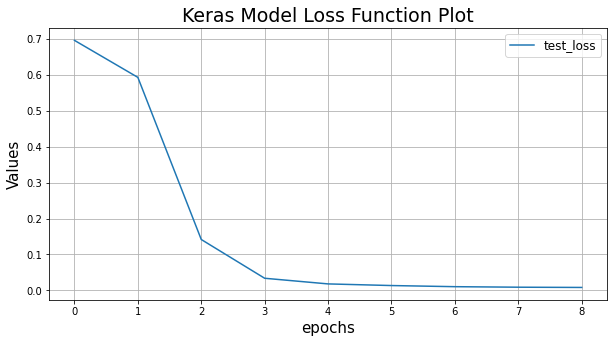

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'],label='test_loss')
#plt.plot(hist.history['val_accuracy'], label='test_val_loss')
#plt.plot(hist.history['accuracy'], label='accuracy')
plt.title('Keras Model Loss Function Plot',fontsize=19)
plt.ylabel('Values',fontsize=15)
plt.xlabel('epochs',fontsize=15)
plt.legend(loc='upper right',fontsize=12)
plt.grid()

plt.show()

In [ ]:
# Aux modelll
import numpy as np
aux_mod = tf.keras.Model(inputs = model.inputs,
                         outputs = model.outputs + [model.layers[0].output],
                         name='aaa-bjk')
x,c= aux_mod.predict(['Hello World'])
np.array(c)[0]

In [49]:
# tf.size(a1)
tf.size(c)

<tf.Tensor: shape=(), dtype=int32, numpy=512>

In [ ]:
# try slicing nowwww

# Siamese model

# Bert Sentence encoder model

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

In [8]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]
train_dataset = SentencesDataset(train_examples, model)

100%|██████████| 245M/245M [00:05<00:00, 47.6MB/s]


In [ ]:
# add column with label to data
data = pd.read_csv("texts.csv")
data = data[['title']].head(1)
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

train_dataloader = DataLoader(data, shuffle=True)
train_loss = losses.CosineSimilarityLoss(model=embedder)

dev_dataloader = DataLoader(data, shuffle=False)
evaluator = EmbeddingSimilarityEvaluator(dev_dataloader)

embedder.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator)

# Doc2Vec

In [12]:
 !gsutil ls gs://rokin-articles

gs://rokin-articles/3DPrinting.json.gz
gs://rokin-articles/3DPrintingIndustry.json.gz
gs://rokin-articles/AddMag.json.gz
gs://rokin-articles/AdditiveManufacturingToday.json.gz
gs://rokin-articles/AllAboutCircuits-v2.json.gz
gs://rokin-articles/AllAboutCircuits.json.gz
gs://rokin-articles/AllElectronics.json.gz
gs://rokin-articles/AluWeb.json.gz
gs://rokin-articles/AntriebsTechnik.json.gz
gs://rokin-articles/Asme.json.gz
gs://rokin-articles/AtpInfo.json.gz
gs://rokin-articles/AutocadMagazin.json.gz
gs://rokin-articles/AutomationMag-v2.json.gz
gs://rokin-articles/AutomationMag.json.gz
gs://rokin-articles/AutomobilIndustrieVogel.json.gz
gs://rokin-articles/Azom.json.gz
gs://rokin-articles/BesserLackieren.json.gz
gs://rokin-articles/BlechOnline.json.gz
gs://rokin-articles/Blechnet.json.gz
gs://rokin-articles/ChannelE.json.gz
gs://rokin-articles/ChemieTechnik.json.gz
gs://rokin-articles/ComputerAutomation.json.gz
gs://rokin-articles/ControlCOM.json.gz
gs://rokin-articles/ControlEng-v2.json.

In [13]:
!gsutil cp gs://rokin-articles/d2v_english.model /content
!gsutil cp gs://rokin-articles/vectorizer-aug.pickle.gz /content


Copying gs://rokin-articles/d2v_english.model...
\ [1 files][ 14.0 MiB/ 14.0 MiB]                                                
Operation completed over 1 objects/14.0 MiB.                                     
Copying gs://rokin-articles/vectorizer-aug.pickle.gz...
\ [1 files][ 11.1 MiB/ 11.1 MiB]                                                
Operation completed over 1 objects/11.1 MiB.                                     


In [14]:
# !pip install gensim
from gensim.models.doc2vec import Doc2Vec
from tqdm import tqdm
import gensim

model_doc= Doc2Vec.load('d2v_english.model')

FileNotFoundError: ignored